# Semana 11: Supernovas
###### Gabriel Missael Barco 08/05/202

In [1]:
#Importamos librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from getdist import plots, MCSamples
import getdist
import pandas as pd
import cosmolopy.distance as distance

#Importamos modulo creado para implementar montecarlo con cadenas de markov
import mcmcGMB as mc

In [2]:
#Extraemos datos
supernova = pd.read_csv("../datos/Supernova/data/jla_lcparams.txt", sep=" ").sort_values(by = "zcmb")
supernova.head()

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,...,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
648,sn1999ac,0.010060,0.009500,0,14.148421,0.174566,0.202688,0.068440,0.048593,0.025981,...,0.128500,51250.610935,0.078970,0.000244,0.000652,-0.000154,3,241.812542,7.972333,-0.008427
691,sn2004s,0.010291,0.009370,0,14.157498,0.173593,-0.117402,0.082511,0.022258,0.024846,...,0.280891,53040.308109,0.290845,-0.000483,0.000665,-0.000348,3,101.431250,-31.231250,-0.008430
641,sn1997do,0.010550,0.010120,0,14.449314,0.173090,0.791332,0.187870,0.118415,0.030547,...,0.280891,50766.597803,0.115604,0.003521,0.000989,0.001322,3,111.677083,47.093333,-0.008434
673,sn2002dp,0.010888,0.011638,0,14.557203,0.169021,-0.316464,0.184325,0.054095,0.023005,...,0.363500,52451.216137,0.133147,0.001596,0.000487,0.001020,3,352.125430,22.427240,-0.008440
713,sn2006bh,0.011184,0.010900,0,14.342973,0.166533,-1.648794,0.032216,-0.083155,0.019407,...,0.352000,53833.523740,0.039787,-0.000039,0.000286,-0.000115,3,340.067078,-66.485085,-0.008446


In [3]:
#Pasamos el DataFrame a un arreglo de Numpy
supernova = np.array(supernova)

In [4]:
#Extraemos y calculamos el error de los datos

matrix0a = pd.read_csv("../datos/Supernova/data/jla_v0a_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrix0b = pd.read_csv("../datos/Supernova/data/jla_v0b_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixv0 = pd.read_csv("../datos/Supernova/data/jla_v0_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixvab = pd.read_csv("../datos/Supernova/data/jla_vab_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixva = pd.read_csv("../datos/Supernova/data/jla_va_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixvb = pd.read_csv("../datos/Supernova/data/jla_vb_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)

matrix = matrix0a + matrix0b + matrixv0 + matrixvab + matrixva + matrixvb
matrix_inv = np.linalg.inv(matrix) 

error = np.zeros(740)

for i in range(740):
    error[i] = np.sqrt(matrix[i][i])

In [25]:
#Definimos el modelo a aplicarse (este trabaja con numpy, ie arreglos completos)
def mu(datos, w):
   
    #Extraemos los datos necesarios
    mb = []
    x1 = []
    color = []
    for i, punto in enumerate(datos):
        mb.append(punto[4])
        x1.append(punto[6])
        color.append(punto[8])
    mb = np.array(mb)
    x1 = np.array(x1)
    color = np.array(color)
    
    #Regresamos el valor de mu
    return mb - (w[2] - w[0]*x1 + w[1]*color)

#Igual que arriba pero para un solo punto
def mu_aux(punto, w):
   
    #Extraemos los datos necesarios
    mb = punto[4]
    x1 = punto[6]
    color = punto[8]
    
    #Regresamos el valor de mu
    return mb - (w[2] - w[0]*x1 + w[1]*color)


#Definimos el valor teorico de mu
def mu_teorico(datos, w):
    #Extraemos los datos necesarios
    zcmb = []
    for punto in datos:
        zcmb.append(punto[1])
    zcmb = np.array(zcmb)
    if w[3]<0:
        w[3]=0
    #Regresamos el valor de mu teorico
    cosmo = {"omega_M_0":w[3],
            "omega_lambda_0":1-w[3],
            "omega_k_0":0.0,
            "h":0.7}
    return 5*np.log10(distance.luminosity_distance(zcmb, **cosmo)*1e6/10)
    
#Esta funcion no sirve para visualizar los datos   
def grafica(x, y, yt):
    fig= plt.figure(figsize = (7, 7))
    gs = fig.add_gridspec(2, 1)
    
    ax0 = fig.add_subplot(gs[0:2, 0])
    ax0.plot(x, y, marker=".", alpha=0.7, label = 'Datos')
    ax0.plot(x, yt, color = "red", label = 'Teoría')
    ax0.grid()
    ax0.set_ylabel("$\mu$")
    ax0.set_xlabel("z")
    ax0.set_xlim(0.005, 2)
    ax0.set_xscale("log")
    
    fig.subplots_adjust(hspace=0)
    plt.show()

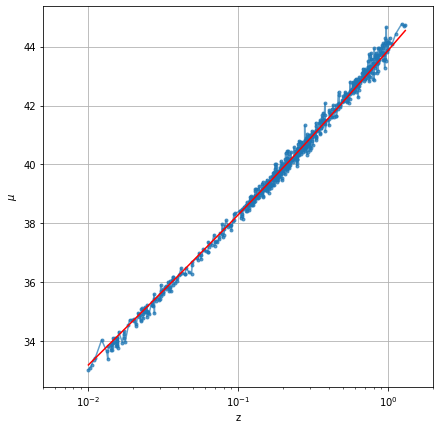

In [26]:
w = [0.1, 3, -19, 0.5]

x = []
for punto in supernova:
    x.append(punto[1])
x = np.array(x)

m = mu(supernova, w)
mt = mu_teorico(supernova, w)
grafica(x, m, mt)

In [27]:
#Definimos likelihood para supernova
def ln_likelihood(datos, parametros, teoria, desviacion_teoria, modelo):
    '''
    DESCRIPTION: Esta funcion regresa un valor proporcional al likelihood
    IN: datos = las x, variable independiente,
        parametros = parametros del modelo
        teoria = las y, variable dependiente,
        desviacion_teoria = desviacion de las y,
        modelo = funcion que aplica el modelo
    OUT: Numero flotante proporcional al liklihood de los parametros dados
    '''
    #Inicializamos la suma
    suma = 0
    teoria = mu_teorico(datos, parametros)
    #Sumamos cada elemento
    for i in range (len(datos)):
        suma += (teoria[i]-modelo(datos[i], parametros))**2/desviacion_teoria[i]**2
    return -(1/2)*suma


#Definimos prior para supernova
def ln_prior(parametros, teoria, desviacion_teoria, modelo):
    '''
    DESCRIPTION: Esta funcion regresa el prios de un conjunto de parametros dados para el modelo
    IN: parametros = lista de parametros
    OUT: lista con numeros flotantes igual a la probabilidad
    
    Nota: en este caso elegimos una probabilidad continua para cada parametro
    '''
    inf = [-5, -2, -24, 0]
    sup = [5, 8, -14, 1]
    p = np.zeros(4)
    
    for i in range(4):
        if inf[i]<parametros[i]<sup[i]:    #SUPERNOVA
            p[i] = -1*np.log(sup[i]-inf[i])
        else:
            p[i] = 0
    
    return sum(p)

In [54]:
#Generamos cadenas de Markov 

np.random.seed(200)
n_cadenas = 5

#Parametros y sus desviaciones
w_real = [0.1, 3, -19, 0.5]
des_w = [0.1, 0.1, 0.1, 0.1]

#Construimos la recta:
x = np.array(supernova)
y = mu_teorico(supernova, w_real)

#Generamos los puntos iniciales de manera alatoria cerca de los valores conocidos
w_iniciales = []
rango = 5
for i in range(n_cadenas):
    w_iniciales.append([])
    for j in range(3):
        w_iniciales[i].append(rango*np.random.randn()+w_real[j])
    w_iniciales[i].append(abs(np.random.randn()))

#Aplicamos el mcmc
cadenas = mc.montecarlo_mc(N = n_cadenas, datos = supernova, desviacion_teoria = error, teoria = y, 
                       modelo = mu_aux, desviacion_parametros = des_w, p_old = w_iniciales, n_pasos = 10000,
                       ln_likelihood = ln_likelihood, ln_prior = ln_prior)

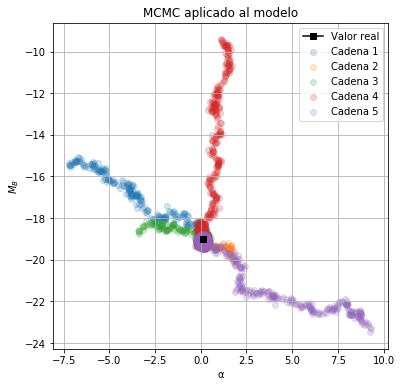

In [55]:
mc.ver_cadenas(cadenas = cadenas[0:5], i_parametro = [0,2], p_reales = w_real, labels = ['α', 'β', '$M_B$', '$\Omega$'])

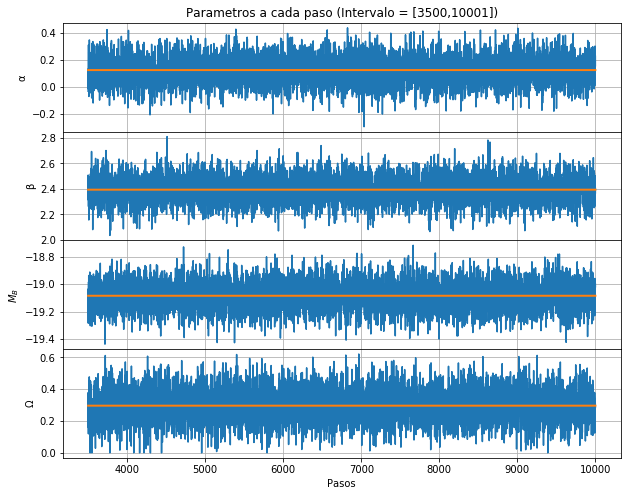

In [65]:
mc.ver_parametros(cadena = cadenas[2], cut = 3500, labels = ['α', 'β', '$M_B$', '$\Omega$'])

In [66]:
ratio = mc.aceptacion(cadenas)

Aceptación de cadena 0 = 0.021497850214978503
Aceptación de cadena 1 = 0.004399560043995601
Aceptación de cadena 2 = 0.0093990600939906
Aceptación de cadena 3 = 0.0202979702029797
Aceptación de cadena 4 = 0.020397960203979604


In [67]:
datos = mc.unir_cadenas(cadenas, cuts = [1500 for x in range(5)])

Removed no burn in


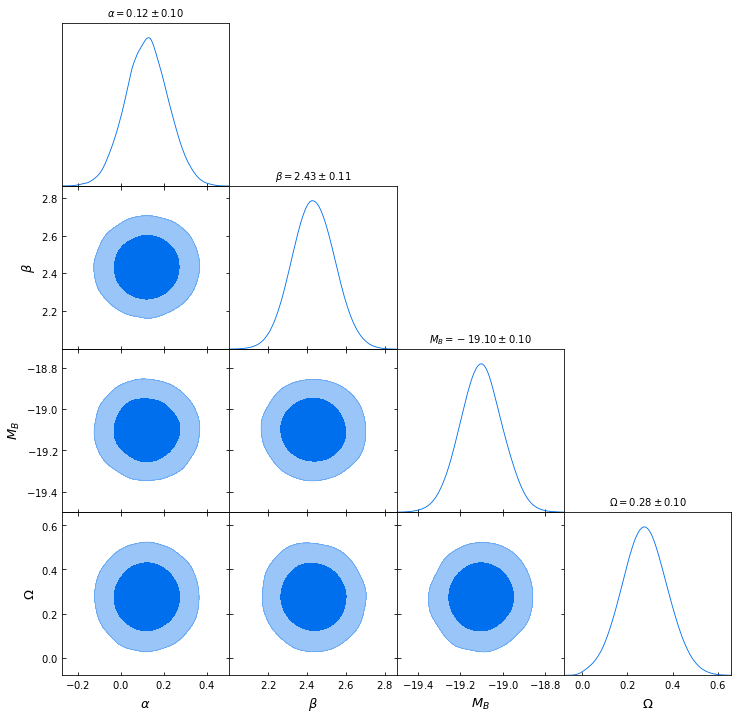

In [68]:
mc.triangulo(datos, labels = ['α', 'β', 'M_B', '\Omega'])

In [71]:
r = mc.resultados(datos)

Parametro 0 = 0.1207 ± (0.09926, 0.09892)
Parametro 1 = 2.432 ± (0.1086, 0.1113)
Parametro 2 = -19.1 ± (0.09883, 0.09983)
Parametro 3 = 0.2752 ± (0.1002, 0.1008)


In [72]:
convergencia = mc.gelman_rubin(cadenas, cut = 1500)

Para el parametro 0, R = 1.0001
Para el parametro 1, R = 1.005
Para el parametro 2, R = 1.0002
Para el parametro 3, R = 1.001
